In [19]:

! git clone https://github.com/chrishon/capstone-camera-traps.git
%cd capstone-camera-traps

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'capstone-camera-traps': No such file or directory
[Errno 2] No such file or directory: 'capstone-camera-traps'
/content/capstone-camera-traps


In [20]:
import video_processing
import torch

In [21]:
from video_processing.prepare_data import extract_frames, prepare_train_data, prepare_train_data_diffusion
from video_processing.post_processing import predict_multiple_samples, multi_sample_frame_analysis, visualize_multiple_comparisons, multi_sample_temporal_analysis, temporal_analysis

In [22]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [23]:
image_size = (128,128)

In [24]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=64,
    in_channels=3 + 5*3,  # Noisy image (3) + condition (5*3)
    out_channels=3,       # Predict noise
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(18, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(1

In [25]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from torch.utils.data import DataLoader, TensorDataset
# 1. Extract and prepare data
video_path="/content/drive/MyDrive/capstone-camera-traps/resources/videos/FH102_02 (1).avi"
frames = extract_frames(video_path,size = (128,128),max_frames = 10)

In [28]:
len(frames)

10

In [29]:

X_condition, y_target = prepare_train_data_diffusion(frames, sequence_length=5)

# 2. Create dataloader
X_tensor = torch.tensor(X_condition, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. Verify shapes
sample_batch = next(iter(train_loader))
condition_batch, target_batch = sample_batch
print(f"Condition shape: {condition_batch.shape}")  # Should be (batch, 15, 64, 64)
print(f"Target shape: {target_batch.shape}")        # Should be (batch, 3, 64, 64)

Condition shape: torch.Size([5, 15, 128, 128])
Target shape: torch.Size([5, 3, 128, 128])


In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 2
for epoch in range(num_epochs):
    i = 1
    for batch_condition, batch_target in train_loader:
        print(i)
        i += 1
        batch_condition = batch_condition.to(device)
        batch_target = batch_target.to(device)

        # Sample noise and timesteps
        noise = torch.randn_like(batch_target)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps,
                                 (batch_target.shape[0],), device=device)

        # Add noise to targets
        noisy_images = noise_scheduler.add_noise(batch_target, noise, timesteps)

        # Combine with condition and predict noise
        model_input = torch.cat([noisy_images, batch_condition], dim=1)
        noise_pred = model(model_input, timesteps).sample

        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

1
Epoch 1, Loss: 1.1524
1
Epoch 2, Loss: 1.0564


In [31]:
def predict_next_frame(model, condition, scheduler, device):
    model.eval()
    with torch.no_grad():
        # Initial noise
        sample = torch.randn((1, 3, 128, 128), device=device)
        condition = condition.unsqueeze(0).to(device)

        # Denoising loop
        for t in scheduler.timesteps:
            model_input = torch.cat([sample, condition], dim=1)
            noise_pred = model(model_input, t).sample
            sample = scheduler.step(noise_pred, t, sample).prev_sample

        # Denormalize and format
        predicted_frame = sample.squeeze().cpu().numpy()
        predicted_frame = (predicted_frame + 1) / 2  # [0, 1]
        predicted_frame = np.transpose(predicted_frame, (1, 2, 0))
        return predicted_frame

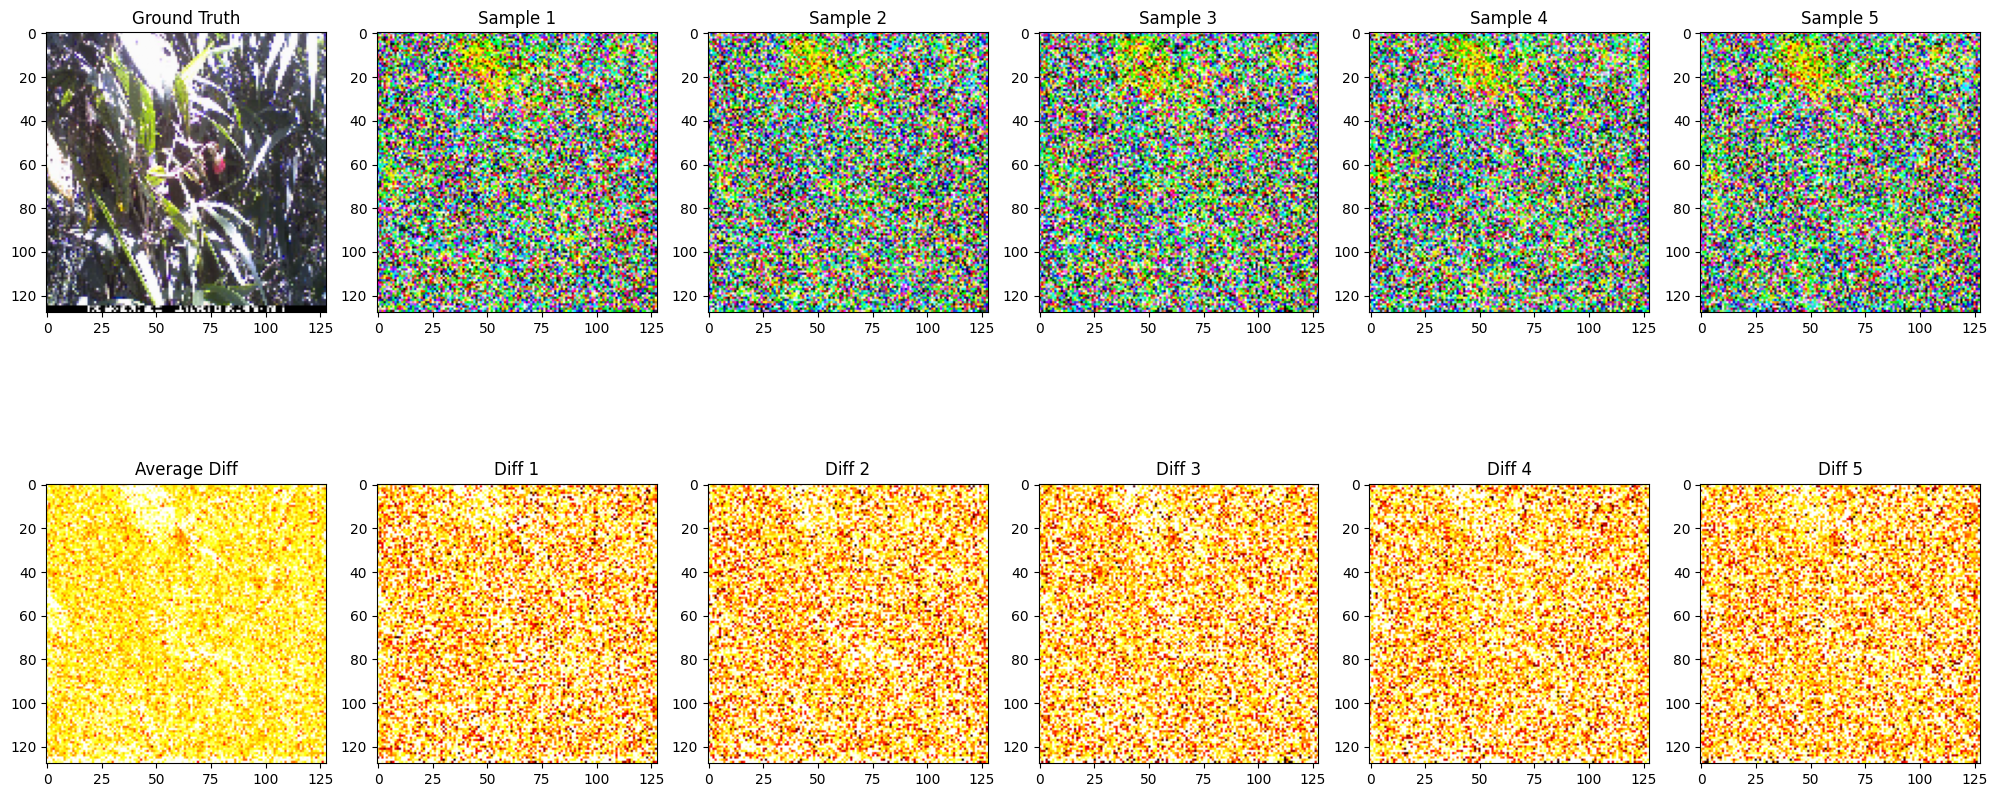

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare test data
X_condition_test, y_test = X_condition, y_target
# X_condition_test, y_test = prepare_train_data(test_frames)

# Select sample
sample_idx = 3
condition_sample = torch.tensor(X_condition_test[sample_idx], dtype=torch.float32)
actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2  # To HWC and [0,1]

# Generate prediction
predictions = predict_multiple_samples(model, condition_sample, noise_scheduler,
                                      device, num_samples=5,size = image_size)

actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2

# Analyze
analysis = multi_sample_frame_analysis(predictions, actual_frame)

# Plot
visualize_multiple_comparisons(predictions, actual_frame)

In [33]:
def prepare_initial_condition(frames):
    """Convert initial frames to model input format"""
    # Convert to numpy array and normalize
    frames_np = np.array(frames) / 255.0 * 2 - 1  # [-1, 1] range

    # Transpose to (seq_len, C, H, W)
    frames_transposed = np.transpose(frames_np, (0, 3, 1, 2))

    # Combine sequence length and channels
    initial_condition = frames_transposed.reshape(1, -1, frames_np.shape[1], frames_np.shape[2])

    return initial_condition


In [35]:
def generate_sequence(
    model,
    initial_condition,
    scheduler,
    device,
    num_frames=3,
    sequence_length=5
):
    """Generate a sequence of frames autoregressively"""
    # Initial setup
    current_condition = initial_condition.clone().to(device)
    predicted_frames = []
    C, H, W = 3, image_size[0], image_size[1]  # Update if your resolution differs

    for _ in range(num_frames):
        # Predict next frame (returns tensor in [-1, 1])
        next_frame = predict_next_frame_tensor(model, current_condition, scheduler, device)
        predicted_frames.append(next_frame.cpu())

        # Update condition: Remove oldest frame, add new prediction
        current_condition = torch.cat([
            current_condition[:, 3:],  # Remove oldest 3 channels
            next_frame.unsqueeze(0)    # Add new prediction
        ], dim=1)

    # Denormalize and format
    denorm_frames = [
        (frame.squeeze().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # [-1,1] → [0,1]
        for frame in predicted_frames
    ]
    return denorm_frames

def predict_next_frame_tensor(model, condition, scheduler, device):
    """Diffusion prediction (returns tensor in [-1, 1])"""
    model.eval()
    with torch.no_grad():
        noise = torch.randn((1, 3, image_size[0], image_size[1]), device=device)
        condition = condition.to(device)

        for t in scheduler.timesteps:
            model_input = torch.cat([noise, condition], dim=1)
            noise_pred = model(model_input, t).sample
            noise = scheduler.step(noise_pred, t, noise).prev_sample

        return noise.squeeze(0)  # (3, H, W)

def get_gt_sequence(frames, start_idx, sequence_length=5, num_frames=3):
    """Extract ground truth sequence from original frames"""
    # Get initial sequence and subsequent frames
    initial_frames = frames[start_idx : start_idx + sequence_length]
    gt_sequence = frames[start_idx + sequence_length : start_idx + sequence_length + num_frames]

    # Convert to [0, 1] range
    gt_sequence = [frame.astype(np.float32) / 255.0 for frame in gt_sequence]
    return gt_sequence

# Parameters
sequence_length = 5
num_pred_frames = 20
start_idx = 0  # Starting point in video

# Get initial frames for conditioning
initial_frames = frames[start_idx : start_idx + sequence_length]

# Prepare initial condition tensor
initial_condition_np = prepare_initial_condition(initial_frames)
initial_condition = torch.tensor(initial_condition_np, dtype=torch.float32).to(device)

# Generate predicted sequence
predicted_sequence = generate_sequence(
    model,
    initial_condition,
    noise_scheduler,
    device,
    num_frames=num_pred_frames
)

# Get ground truth sequence
gt_sequence = get_gt_sequence(
    [f.astype(np.uint8) for f in frames],  # Original uint8 frames
    start_idx,
    num_frames=num_pred_frames
)

In [36]:


# Analyze sequences
pred_metrics = temporal_analysis(predicted_sequence)
gt_metrics = temporal_analysis(gt_sequence)

# Compare metrics
def compare_metrics(pred, gt):
    print(f"{'Metric':<25} {'Predicted':<10} {'GT':<10} {'Diff':<10}")
    for key in pred:
        p_val = np.mean(pred[key])
        g_val = np.mean(gt[key])
        print(f"{key:<25} {p_val:.4f}     {g_val:.4f}     {abs(p_val - g_val):.4f}")

compare_metrics(pred_metrics, gt_metrics)

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [ ]:
def plot_temporal_comparison(pred_metrics, gt_metrics):
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    metrics = ['flow_magnitude', 'intensity_change', 'temporal_ssim']

    for i, metric in enumerate(metrics):
        axs[i].plot(pred_metrics[metric], label='Predicted')
        axs[i].plot(gt_metrics[metric], label='Ground Truth')
        axs[i].set_title(metric.replace('_', ' ').title())
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_temporal_comparison(pred_metrics, gt_metrics)

In [ ]:
from video_processing.post_processing import frame_analysis, visualize_comparison, temporal_analysis

In [ ]:
analysis_results = frame_analysis(predicted_frame, actual_frame)
analysis_results

In [ ]:
visualize_comparison(predicted_frame, actual_frame)